In [1]:
#Control time packages
import time
import os
import matplotlib.pyplot as plt
from numpy.core import machar
os.environ["OMP_NUM_THREADS"] = "1"

import autolens as al
import autolens.plot as aplt
import numpy as np

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

from schwimmbad import MPIPool

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/SDP81/Autolens/ALMA/Data"#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)        #MGE decomposition

boundary = {'ml': [0.5, 15], 'kappa_s': [0, 2], 'r_s': [5, 30], 'qDM': [0.1, 1], 'log_mbh':[7, 11],
                    'mag_shear': [0, 0.1], 'phi_shear': [0, 179], 'gamma': [0.95, 1.05]}

class Model(object):

    def __init__(self, mass_model, masked_image):
        self.mass_profile  = mass_model
        self.masked_image = masked_image

    def prior_transform(self, theta):
        ml, kappa_s, qDM, r_s, log_mbh, mag_shear, phi_shear, gamma = theta
        parsDic = {"ml": ml, "kappa_s": kappa_s, "r_s": r_s, "qDM": qDM,
                        "log_mbh":log_mbh, "mag_shear": mag_shear, "phi_shear": phi_shear, 
                        "gamma": gamma}
        for key in parsDic:
            parsDic[key] = boundary[key][0] + parsDic[key]*(boundary[key][1] - boundary[key][0])
            
        return np.array(list(parsDic.values()))

    def log_likelihood(self, pars):
        quiet=False
        ml_model, kappa_s_model, r_s_model, qDM_model, log_mbh_model, mag_shear_model, phi_shear_model, gamma_model = pars
        
        ell_comps = al.convert.elliptical_comps_from(axis_ratio=qDM_model, phi=0.0) #Elliptical components in Pyautolens units
        eNFW = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_s_model,elliptical_comps=ell_comps, scale_radius=r_s_model) #Set the analytical model
        self.mass_profile.Analytic_Model(eNFW)        #Include analytical model
        self.mass_profile.MGE_Updt_parameters(ml=ml_model, mbh=10**log_mbh_model, gamma=gamma_model)
        shear_comp_model = al.convert.shear_elliptical_comps_from(magnitude=mag_shear_model, phi=phi_shear_model)
        #New lens model
        lens_galaxy = al.Galaxy(                                            
                redshift=self.mass_profile.z_l,
                mass=self.mass_profile,
                shear=al.mp.ExternalShear(elliptical_comps=shear_comp_model),
            )

        source_galaxy = al.Galaxy(
                redshift=self.mass_profile.z_s,
                pixelization=al.pix.Rectangular(shape=(40, 40)),
                regularization=al.reg.Constant(coefficient=1.5),
            )
        tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])
        
        try:
            fit = al.FitImaging(masked_imaging=self.masked_image, tracer=tracer)

            log_evidence = fit.log_evidence

                
            if quiet is False:
                print("Lens Galaxy Configuration:")
                print("Log Likelihood_with_regularization:", fit.log_likelihood)
                print("Log Normalization", fit.log_likelihood)
                print("Log Evidence:", fit.log_evidence)
                print("#------------------------------------#")
                print(lens_galaxy)
                print("\n")


                aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True))
                aplt.Inversion.reconstruction(fit.inversion)              


            return log_evidence, fit
        except:
            print("An exception ocurres in Pyautolens_log_likelihood().")
            return -np.inf
    
    def __call__(self, pars):
        return self.log_likelihood(pars)

def resume_dlogz(sampler):
        results = sampler.results
        logz_remain = np.max(sampler.live_logl) + results.logvol[-1]
        delta_logz = np.logaddexp(results.logz[-1], logz_remain) - results.logz[-1]
        
        return delta_logz

In [2]:
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 3.042                                                         #Source Redshift 
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
kappa_ = 0.075                                                         #kappa_s of DM profile
r_s    = 11.5
ml     = 7.00                                                          #mass to light ratio
phi_shear = 88                                                         #Inclination of external shear [deg]
mag_shear = 0.02                                                       #magnitude of shear
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=mag_shear, phi=phi_shear) #external shear

#Autolens Data
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/Alma_with_lens_center.fits",
        noise_map_path=f"{data_folder}/rms_noise_map.fits",
        psf_path=f"{data_folder}/Alma_psf_rot.fits",
        pixel_scales=0.02,
        image_hdu=1, noise_map_hdu=1, psf_hdu=1,
    )

mask        = al.Mask.from_fits( file_path=f"{data_folder}/mask.fits", 
                                pixel_scales=imaging.pixel_scales)

masked_image = al.MaskedImaging(imaging=imaging, mask=mask, inversion_uses_border=True)   #Masked image
#aplt.Imaging.subplot_imaging(imaging=imaging, mask=mask)

#--------------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------------#
# PYAUTOLENS MODEL
#MGE mass profile

#Initializing
mass_profile = al.mp.MGE()
ell_comps = al.convert.elliptical_comps_from(axis_ratio=0.85, phi=0.0) #Elliptical components in Pyautolens units
eNFW      = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_, elliptical_comps=ell_comps, scale_radius=r_s) #pseudo elliptical NFW


#Components

mass_profile.MGE_comps(z_l=z_l, z_s=z_s, 
                    surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                    mbh=mbh)
mass_profile.Analytic_Model(analytic_profile=eNFW)



#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_l,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

source_galaxy = al.Galaxy(
    redshift=z_s,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.50),
)

print("Starting functions... \n")
start = time.time()
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])
fit = al.FitImaging(masked_imaging=masked_image, tracer=tracer)

#aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True,critical_curves=False,caustics=False))
print("Log Likelihood with Regularization:", fit.log_likelihood_with_regularization)
print("Log Evidence:", fit.log_evidence)
print("Log Likelihood :", fit.log_likelihood)
print("Elapsed Time [s]:", (time.time() - start))

#Defing Model
#model = Model(mass_model=mass_profile, masked_image=masked_image)

Starting functions... 

Log Likelihood with Regularization: 40578.92892822808
Log Evidence: 36911.054314794455
Log Likelihood : 40579.14389411796
Elapsed Time [s]: 11.19827675819397


In [3]:
import pickle
with open(f'dynesty_lens.pickle','rb') as f:
    sample_load = pickle.load(f)
    
with open(f'dynesty_lens2.pickle','rb') as f:
    sample_load2 = pickle.load(f)

sample_load2.add_final_live()
    
results1 = sample_load.results
results2 = sample_load2.results

results1.summary()
results2.summary()

iter: 688 | +40 | bound: 13087 | nc: 1 | ncall: 793646 | eff(%):  0.092 | loglstar:   -inf < 40371.340 <    inf | logz: 40350.890 +/-  0.782 | dlogz:  0.575 >  0.010                                 

Summary
nlive: 200
niter: 4222
ncall: 80691
eff(%):  5.480
logz: 40334.138 +/-  0.924
Summary
nlive: 40
niter: 688
ncall: 793646
eff(%):  0.092
logz: 40350.890 +/-  0.782


In [4]:
sample_load.sampling, sample_load2.sampling

('rwalk', 'unif')

/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))


ValueError: Axis limits cannot be NaN or Inf

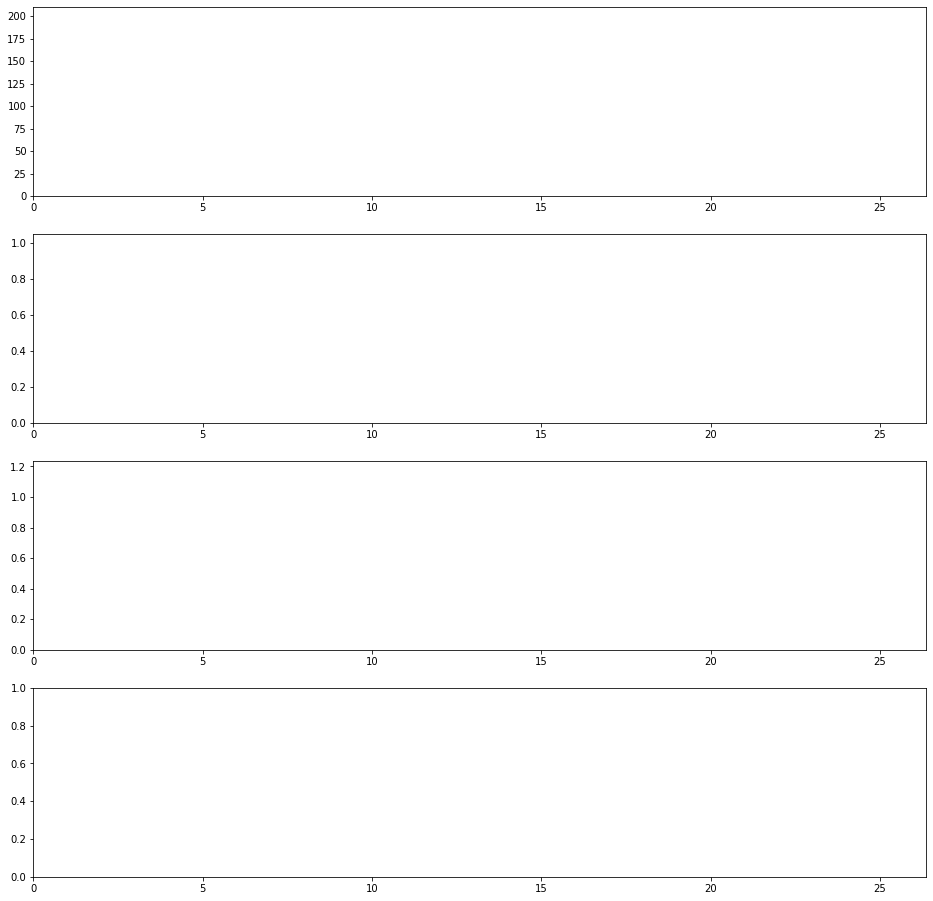

In [17]:
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

results = dyfunc.merge_runs([results1, results2])
fig, axes = dyplot.runplot(results)

In [18]:
from dynesty import utils as dyfunc
labels = ["ml", "kappa_s", "rs","qDM",
                    "log_mbh", "mag_shear", "phi_shear", 
                    "gamma"]

# Generate a new set of results with statistical+sampling uncertainties.
results_sim = results


samples_sim = results_sim.samples
weights = np.exp(results_sim.logwt - results_sim.logz[-1])  # normalized weights
mean, cov = dyfunc.mean_and_cov(samples_sim, weights)
mean, cov

(array([3.58858162e+00, 7.20049647e-03, 1.77443680e+01, 7.14904174e-01,
        9.65995681e+00, 5.13180015e-02, 1.55090524e+02, 9.77201654e-01]),
 array([[ 5.41022679e-01,  6.94869064e-04, -8.14455067e+00,
          3.89786206e-02, -6.34146403e-01, -2.01143133e-03,
          7.84178314e+00, -1.86654382e-02],
        [ 6.94869064e-04,  7.74898607e-06, -1.88716910e-02,
          1.38167393e-05, -1.02447055e-03,  4.36048203e-06,
          1.66597851e-02, -2.74745725e-05],
        [-8.14455067e+00, -1.88716910e-02,  1.33161155e+02,
         -5.41752089e-01,  9.80743621e+00,  2.15876784e-02,
         -1.25346279e+02,  2.85005055e-01],
        [ 3.89786206e-02,  1.38167393e-05, -5.41752089e-01,
          3.00866964e-03, -4.45761314e-02, -1.82592547e-04,
          5.24692849e-01, -1.32434247e-03],
        [-6.34146403e-01, -1.02447055e-03,  9.80743621e+00,
         -4.45761314e-02,  7.49787546e-01,  2.14299303e-03,
         -9.37578022e+00,  2.19793448e-02],
        [-2.01143133e-03,  4.36048

/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:1239: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(n) * 1.05])
/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:2166: RuntimeWarning: invalid value encountered in true_divide
  sm /= sm[-1]
/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:2170: RuntimeWarning: invalid value encountered in less_equal
  V[i] = Hflat[sm <= v0][-1]


KeyboardInterrupt: 

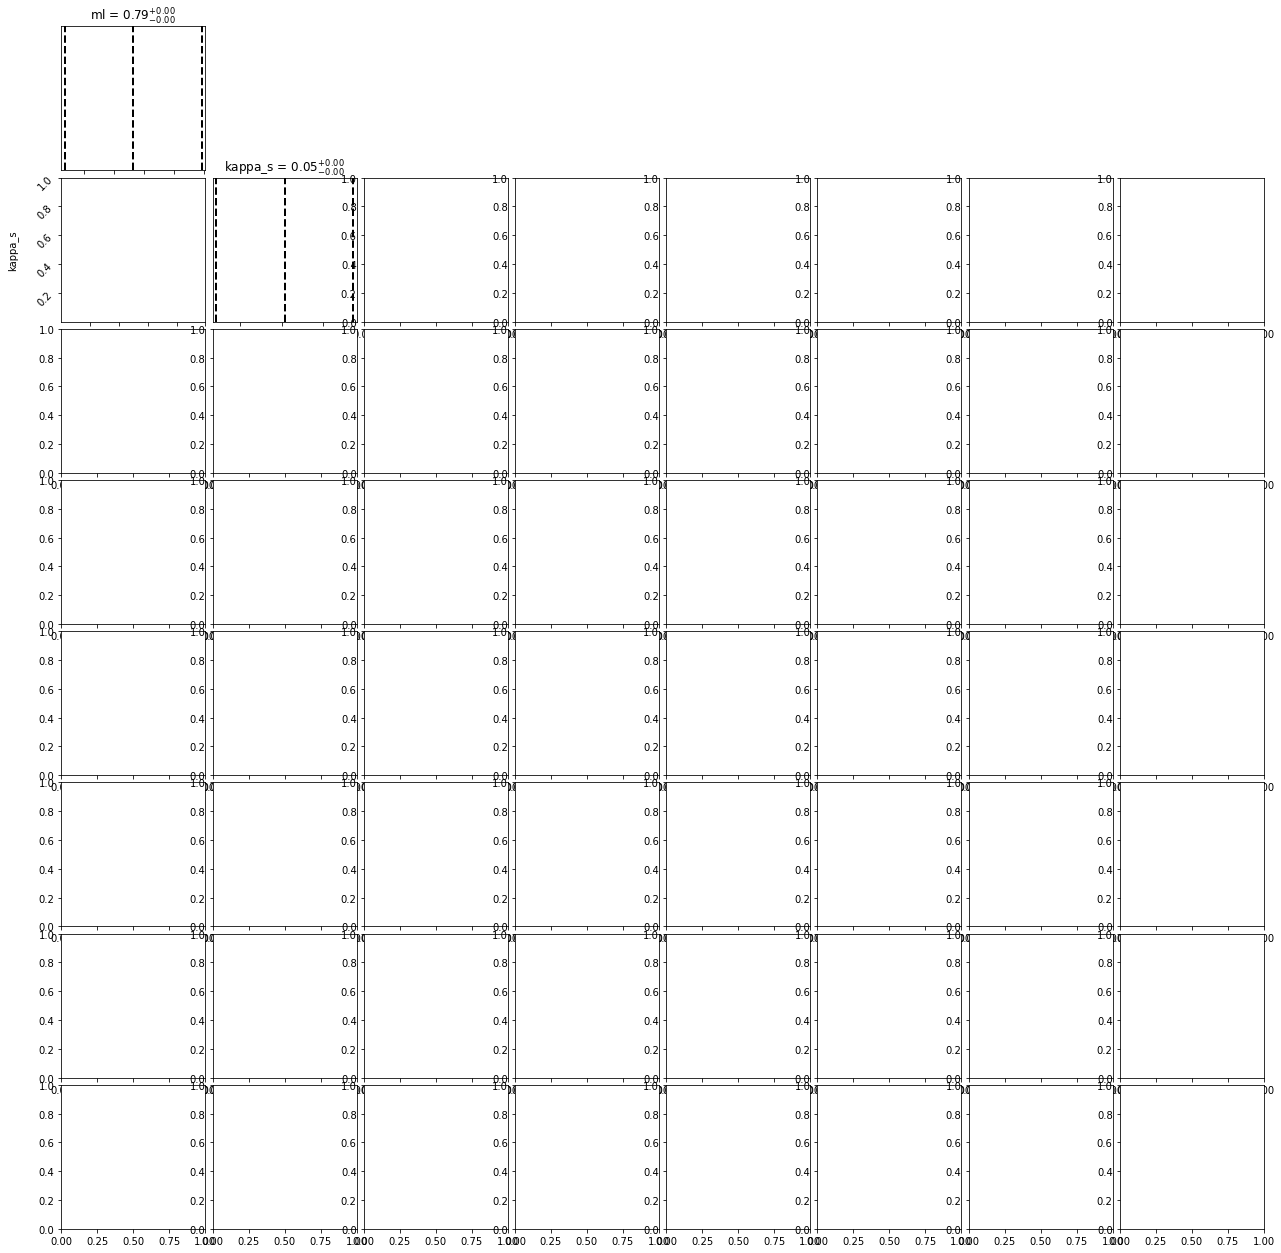

In [6]:
labels = ["ml", "kappa_s", "rs", "qDM",
                    "log_mbh", "mag_shear", "phi_shear", 
                    "gamma"]
cfig, caxes = dyplot.cornerplot(results_sim,show_titles=True,labels=labels,
                               )

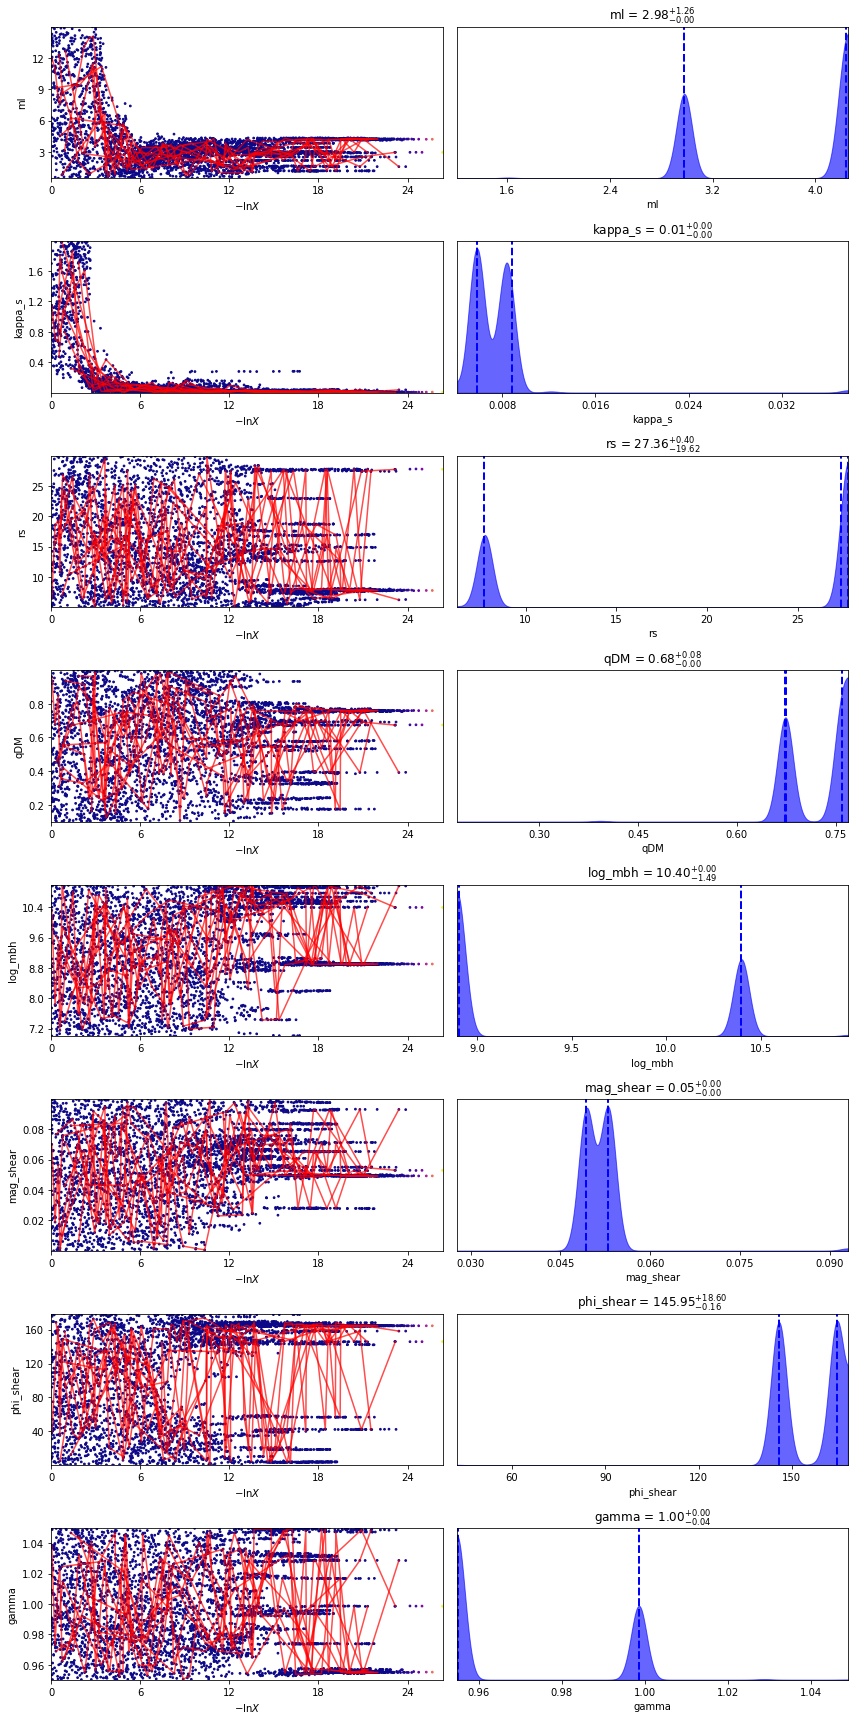

In [19]:
rfig, raxes = dyplot.traceplot(results_sim, labels=labels,
                               show_titles=True, connect=True, )
plt.tight_layout()

In [20]:
model = Model(mass_model=mass_profile, masked_image=masked_image)

Lens Galaxy Configuration:
Log Likelihood_with_regularization: 43948.25556351277
Log Normalization 43948.25556351277
Log Evidence: 40039.45302732053
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 0.9772016541867077
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.1662459219584414)
axis_ratio: 0.7149041744484395
phi: 0.0
kappa_s: 0.007200496466031813
scale_radius: 17.74436798921635
inner_slope: 1.0
z_l: 0.299
z_s: 3.042
critical_density: 2164845147317488.8
surf_lum: [1.79642955e+04 5.06247308e+03 7.28033611e+02 2.77239730e+02
 1.39133048e+02 9.16597040e+01 4.00566790e+01 2.95544940e+01
 1.75839440e+01]
sigma_lum: [0.04569  0.13247  0.263819 0.554257 0.691878 1.070566 1.479681 2.651813
 2.651813]
qobs_lum: [0.718002 0.616098 0.819906 1.       0.468808 1.       0.571622 0.612282
 1.      ]
ml: 3.5885816227461533
surf_dm: None
sigma_dm: None
qobs_dm: None

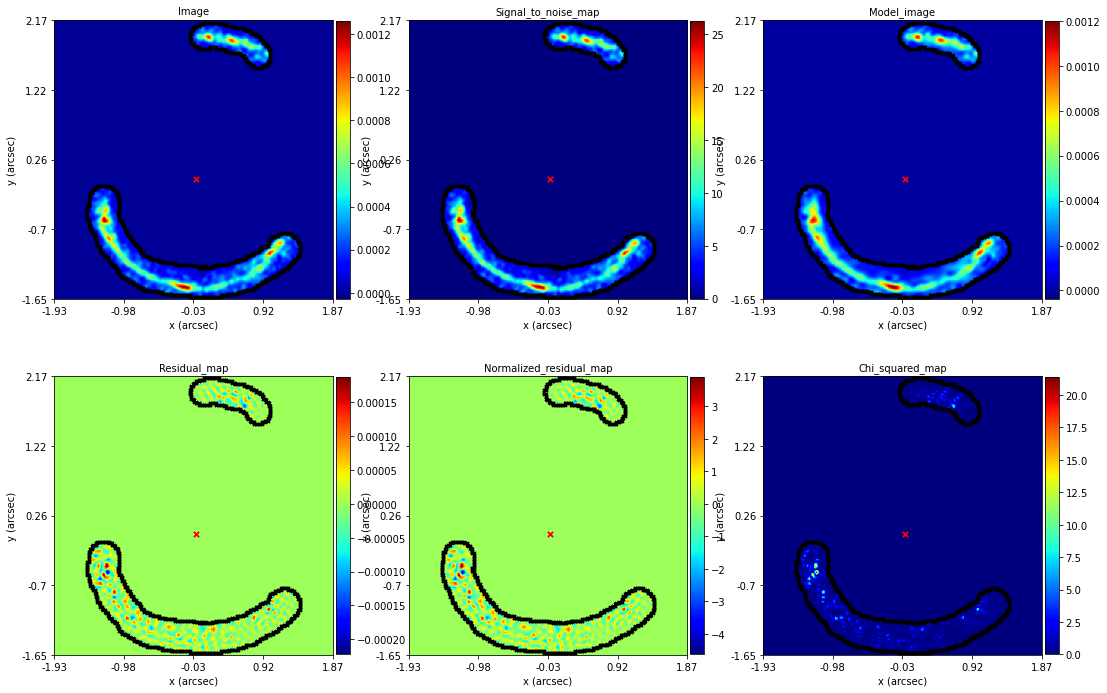

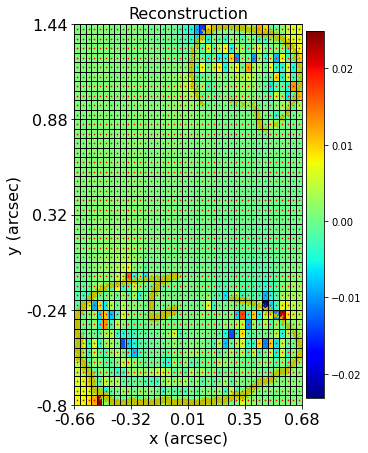

In [21]:
log_evi, fit_fun = model(mean)

In [22]:

samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
mean, cov = dyfunc.mean_and_cov(samples, weights)
mean

array([1.45957565e+00, 4.05742679e-02, 1.80088794e+01, 9.58693811e-01,
       1.08663314e+01, 9.63007084e-02, 1.57507536e+02, 9.83287703e-01])

Lens Galaxy Configuration:
Log Likelihood_with_regularization: 43916.67461370128
Log Normalization 43916.67461370128
Log Evidence: 40274.51681169589
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 0.9832877034427816
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.02108864013867349)
axis_ratio: 0.9586938110763638
phi: 0.0
kappa_s: 0.04057426786888842
scale_radius: 18.00887944258261
inner_slope: 1.0
z_l: 0.299
z_s: 3.042
critical_density: 2164845147317488.8
surf_lum: [1.79642955e+04 5.06247308e+03 7.28033611e+02 2.77239730e+02
 1.39133048e+02 9.16597040e+01 4.00566790e+01 2.95544940e+01
 1.75839440e+01]
sigma_lum: [0.04569  0.13247  0.263819 0.554257 0.691878 1.070566 1.479681 2.651813
 2.651813]
qobs_lum: [0.718002 0.616098 0.819906 1.       0.468808 1.       0.571622 0.612282
 1.      ]
ml: 1.4595756467910979
surf_dm: None
sigma_dm: None
qobs_dm: None

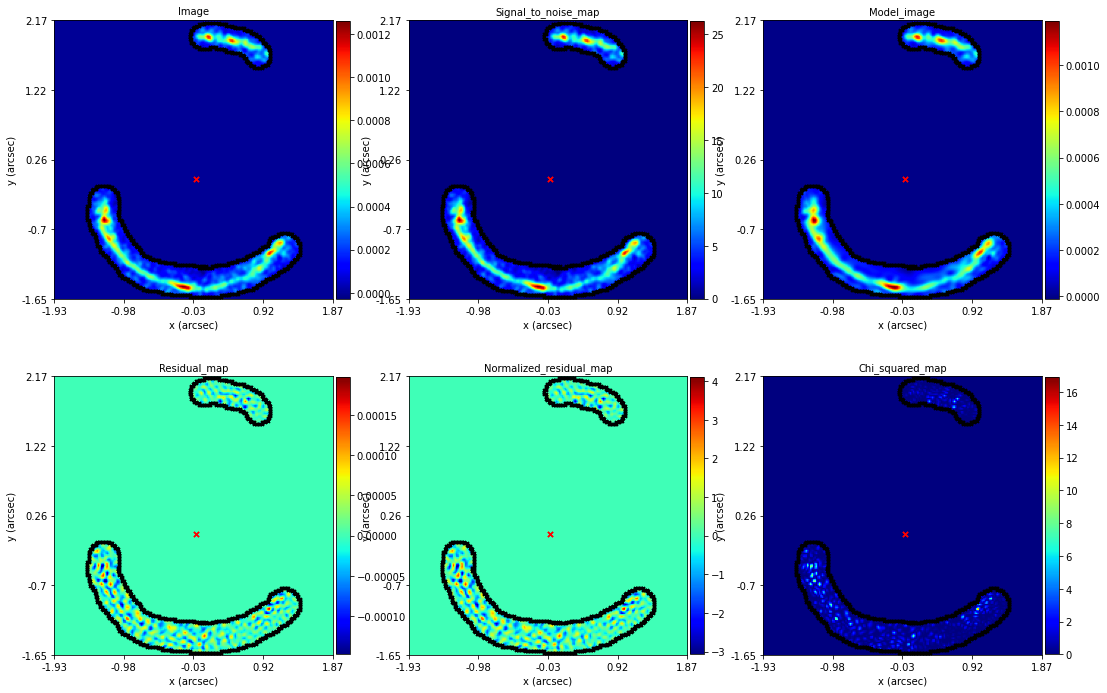

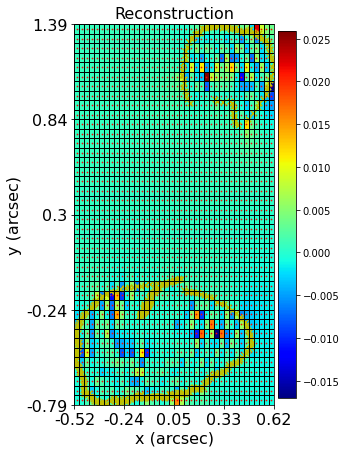

In [11]:
log_evi, fit_fun = model(mean)

In [12]:
results2.niter

688

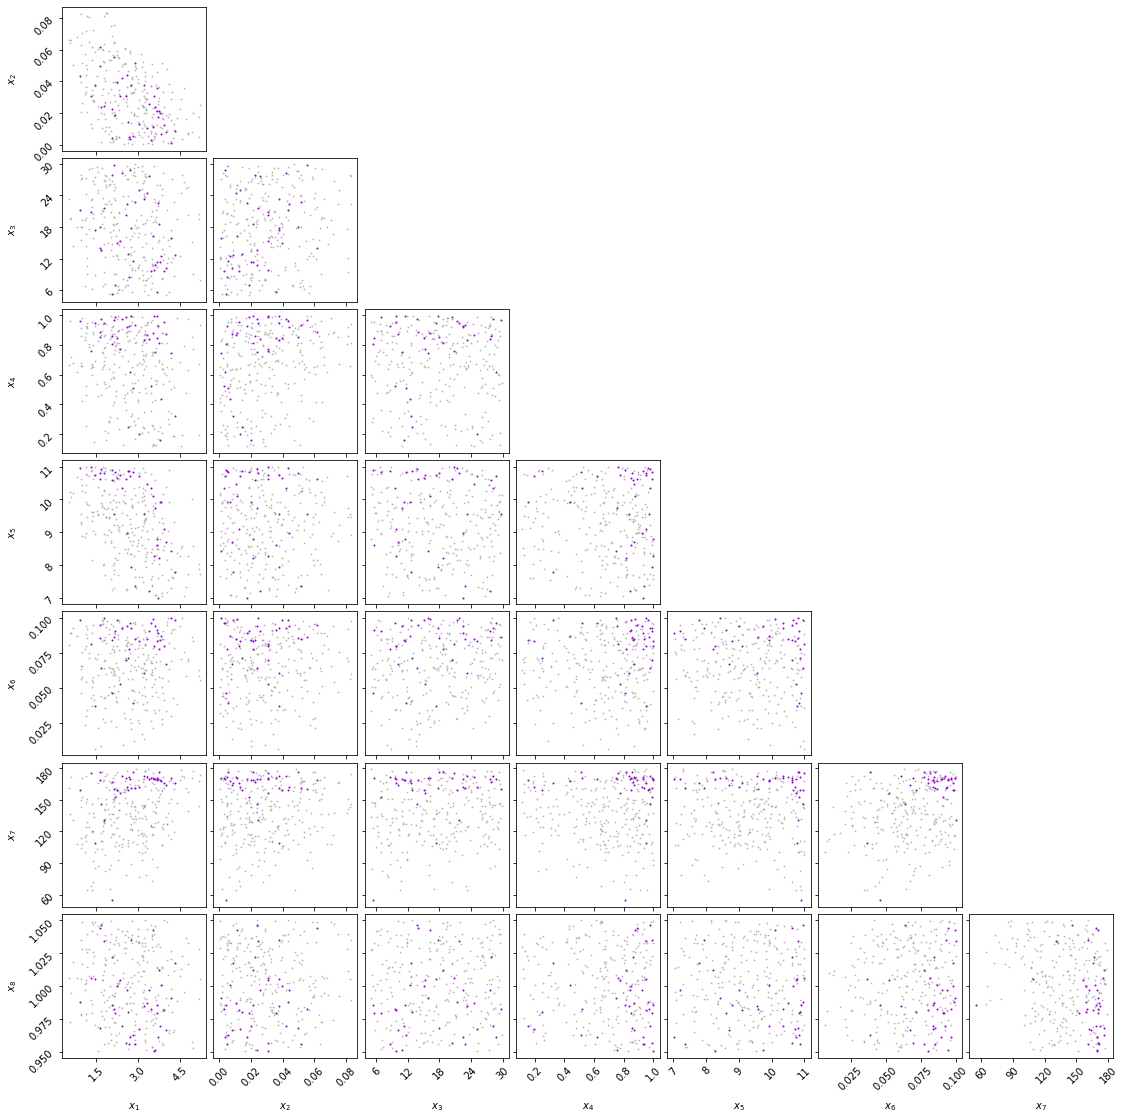

In [14]:
# plot proposals in corner format for 'none'
fg, ax = dyplot.cornerbound(results2, it=639,prior_transform=sample_load.prior_transform,
                            show_live=True)

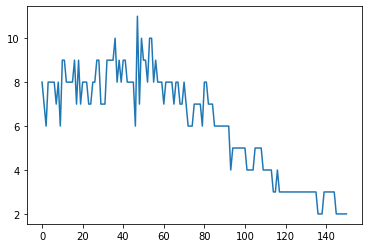

In [13]:
nells = []
for bound in results1.bound[1:]:
    nells.append(bound.nells)
plt.plot(nells)

In [14]:
sample_load.results.bound_iter.size

4422

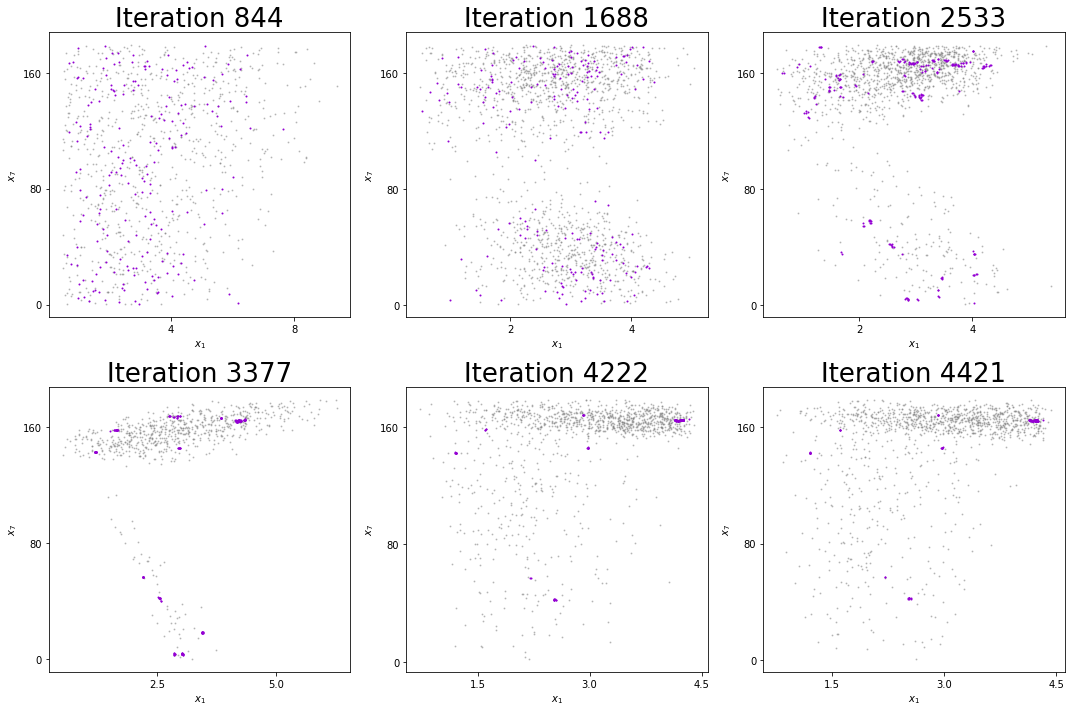

In [15]:
# initialize figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# plot 6 snapshots over the course of the run
for i, a in enumerate(axes.flatten()):
    it = int((i+1)*sample_load.results.niter/5.)
    if it > sample_load.results.niter:
        it = sample_load.results.bound_iter.size-1
    # overplot the result onto each subplot
    temp = dyplot.boundplot(sample_load.results, dims=(0, 6), it=it, prior_transform=sample_load.prior_transform, max_n_ticks=3,
                            show_live=True, fig=(fig, a))
    a.set_title('Iteration {0}'.format(it), fontsize=26)
fig.tight_layout()



In [119]:
# compute effective 'multi' volumes
multi_vols = [1.]  # unit cube
for bound in results1.bound[1:]:  # skip unit cube
    vol, funit = bound.monte_carlo_vol(return_overlap=True)
    multi_vols.append(vol * funit)  # numerical estimate via Monte Carlo methods
multi_vols = np.array(multi_vols)

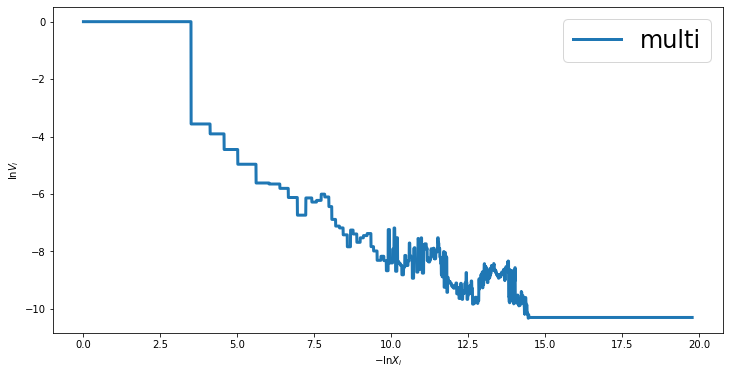

In [121]:


# plot results as a function of ln(volume)
plt.figure(figsize=(12,6))
plt.xlabel(r'$-\ln X_i$')
plt.ylabel(r'$\ln V_i$')

# 'multi'
res = results1
x, it = -res.logvol, res.bound_iter
y = np.log(multi_vols[it])
plt.plot(x, y, lw=3, label='multi')
plt.legend(loc='best', fontsize=24);

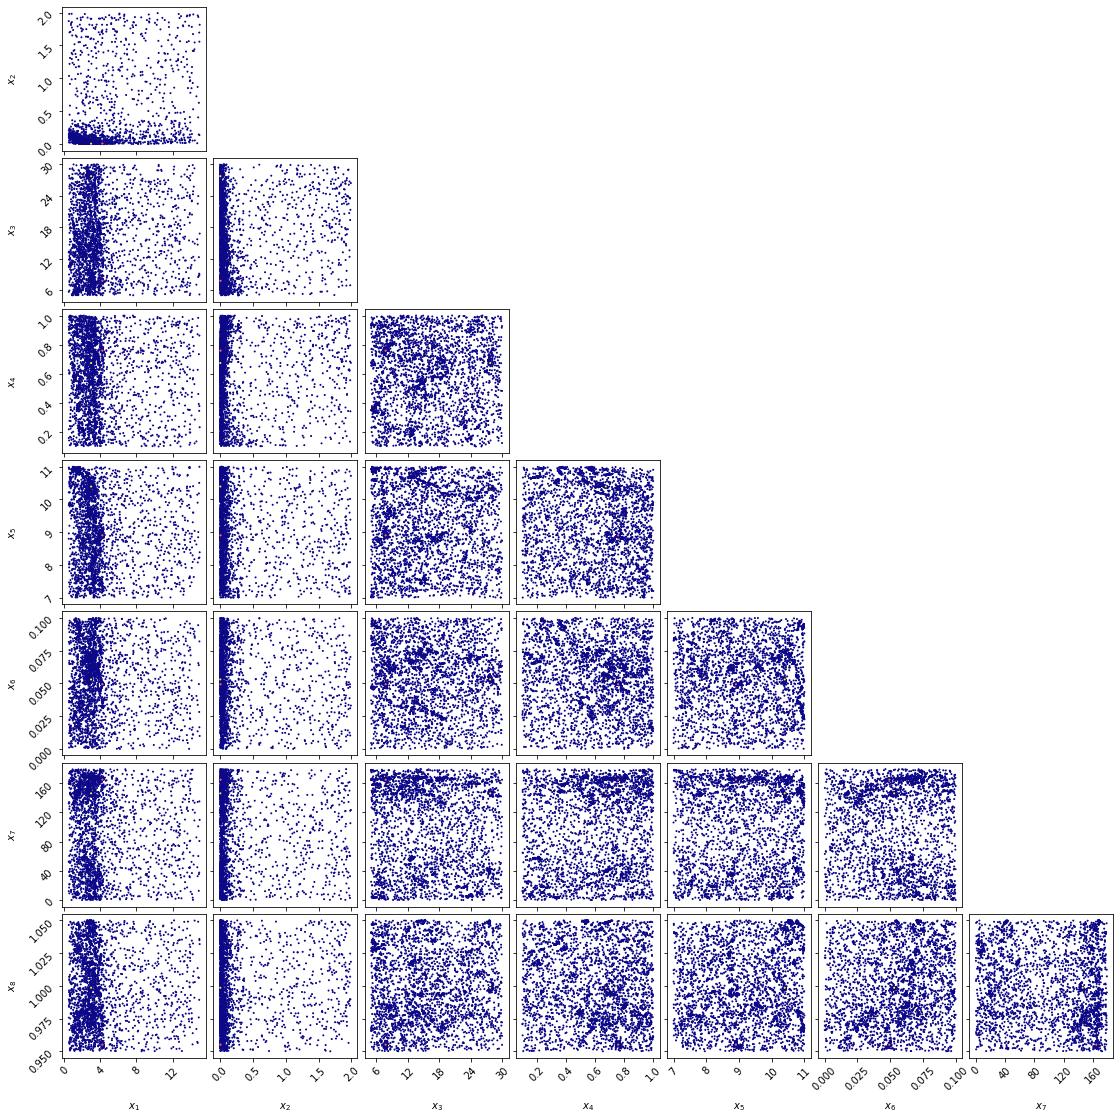

In [25]:
fg, ax = dyplot.cornerpoints(results1, cmap='plasma',
                             kde=False,)